<a href="https://colab.research.google.com/github/sam-israel/Global-Terrorism-Database/blob/master/burn/grossman/person-noperson/svm/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Used code from https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c

In [0]:
DEBUG_MODE = False


In [0]:

import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import os
from PIL import Image
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

## Functions for extracting features from images

Pretrained model for feature extration

In [0]:
# import pretrained resnet 18 
model = models.resnet18(pretrained=True)

These are the layers of resnet18, (from https://pytorch-zh.readthedocs.io/en/latest/_modules/torchvision/models/resnet.html ) 


    def __init__(self, block, layers, num_classes=1000):
        inplanes = 64
        super(ResNet, self).__init__()
        conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        bn1 = nn.BatchNorm2d(64)
        relu = nn.ReLU(inplace=True)
        maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        layer1 = self._make_layer(block, 64, layers[0])
        layer2 = self._make_layer(block, 128, layers[1], stride=2)
        layer3 = self._make_layer(block, 256, layers[2], stride=2)
        layer4 = self._make_layer(block, 512, layers[3], stride=2)
        avgpool = nn.AvgPool2d(7)
        fc = nn.Linear(512 * block.expansion, num_classes)


In [0]:
lastlayer = model._modules.get('avgpool')

Set the model to evaluation mode (not training mode)

In [0]:
model.eval()

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
(https://pytorch.org/docs/master/torchvision/models.html)

In [0]:
scaler = transforms.Scale((224,224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


get image

In [0]:
def image2vec(image):
  
  t_img = normalize(to_tensor(scaler(image)))
  
  # unsqueeze : is reshape our image from (3, 224, 224) to (1, 3, 224, 224). 
  # PyTorch expects a 4-dimensional input, the first dimension being the number of samples.
  t_img = t_img.unsqueeze(0)
  

  # create a pytorch variable
  t_img = Variable(t_img)
    
  # create a variable of 512 zeros (the number of outputs of avgpool layer)
  features = torch.zeros(512)
  
  # a function for copying the result of a layer
  def copy_data(mymodel, myinput, myoutput):
    features.copy_(myoutput.data.squeeze())
    
  # attach copy_data to the 'avgpool' layer. 
  handle =lastlayer.register_forward_hook(copy_data)
  
  # Evaluate the model on the image
  model(t_img)
  
  # Detach the hook
  handle.remove()
   
  return features
  
  
                   
  

test that it works

In [0]:
os.chdir('/content/drive/My Drive/fellowship/nonperson/code')

cat1 = Image.open('testcat1.jpg')
dog1 = Image.open('testdog1.jpg')
cat2 = Image.open('testcat2.jpg')

catvec = image2vec(cat1)
dogvec = image2vec(dog1)
catvec2 = image2vec(cat2)


# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(catvec.unsqueeze(0),
              catvec2.unsqueeze(0))
print('\nCosine similarity between cat1, cat2: {0}\n'.format(cos_sim))

cos_sim = cos(catvec.unsqueeze(0),
              dogvec.unsqueeze(0))
print('\nCosine similarity between cat1, dog: {0}\n'.format(cos_sim))




Cosine similarity between cat1, cat2: tensor([0.7678])


Cosine similarity between cat1, dog: tensor([0.5707])



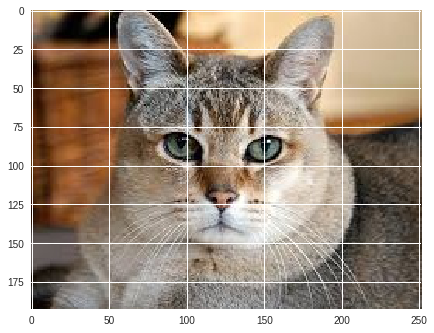

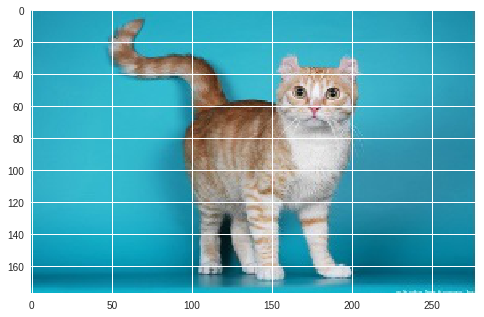

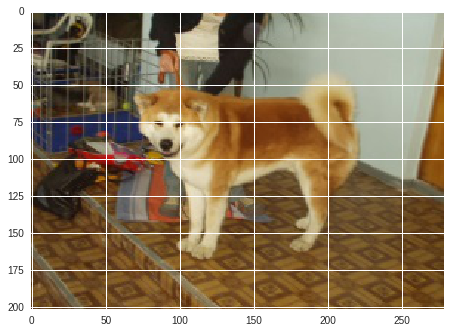

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [0]:
plt.imshow(cat1)
plt.show()
plt.figure()
plt.imshow(cat2)
plt.show()
plt.figure()
plt.imshow(dog1)
plt.show()
plt.figure()

## Use one class svm

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm



### Function for extracting features using image2vec from all files in a given directory

In [0]:
def vec_from_dir(directory):

  flist = os.listdir(directory)
  first = True

  for f in flist :
    if flist.index(f) % 100 == 0:
      print('Processing image #' + str(flist.index(f)) + ' out of ' 
            + str(len(flist)) + ' in directory ' + str(directory) )

    img = Image.open(directory/f).convert('RGB') # not all images are in RGB!
    vec = image2vec(img)
    if first:
  #     res_vec = vec.unsqueeze(1) # vertical concat
      res_vec = vec.unsqueeze(0)
      first=False
    else:

      if DEBUG_MODE:
        print('res vec shape ' + str(res_vec.shape) + ' vec unsqueeze shape ' + str(vec.unsqueeze(1).shape))

  #   res_vec = torch.cat((res_vec, vec.unsqueeze(1)),1) #vertical concat
      res_vec = torch.cat((res_vec, vec.unsqueeze(0)),0)

    img.close()


  return res_vec



### Extract features from all the directories

The dataset used is gs://platform-ai-research/datasets/burn/person-noperson/

It was createed by Richad Lipkin : "Uses web scraped dataset (gs://platform-ai-research/datasets/burn/burn-resplit-out/) as the "person" dataset

Uses the fastai version of the CIFAR10 dataset (500 images of each of 10 categories) as the starting point for the "no person" dataset. Then, RL manually went through and deleted images containing people or human body parts. The final result is 4797 images across the 10 categories.  "





train_persons_dir - the directory of persons we train upon

 train_non_persons_dir - the directory of nonpersons we train upon

test_persons_dir - the directory of persons we test upon

test_Nonpersons_dir - the directory of non person we test upon

Takes some time, the following needs to be run one time only! After that, the saved objects can be loaded.

In [0]:
# train_non_persons_dir = Path('/content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson')

# train_persons_dir = Path('/content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/person')
# test_persons_dir = Path('/content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/valid/person')
# test_Nonpersons_dir = Path('/content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/valid/noperson')



# train_non_persons_results = vec_from_dir(train_non_persons_dir)

# train_results = vec_from_dir(train_persons_dir)
# test_person_results = vec_from_dir(test_persons_dir)
# test_Nonperson_results = vec_from_dir(test_Nonpersons_dir)

# os.chdir('/content/drive/My Drive/fellowship/nonperson/data/svm')

# torch.save(train_non_persons_results, 'train_non_person_results.pt')
# torch.save(train_results, 'train_results.pt')
# torch.save(test_person_results, 'test_person_results.pt')
# torch.save(test_Nonperson_results, 'test_Nonperson_results.pt')




Processing image #3100 out of 3840 in directory /content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson
Processing image #3200 out of 3840 in directory /content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson
Processing image #3300 out of 3840 in directory /content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson
Processing image #3400 out of 3840 in directory /content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson
Processing image #3500 out of 3840 in directory /content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson
Processing image #3600 out of 3840 in directory /content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson
Processing image #3700 out of 3840 in directory /content/drive/My Drive/fellowship/nonperson/data/RL-dataset/person-noperson/train/noperson
Processing image #38

Load the results, previously saved

In [0]:
os.chdir('/content/drive/My Drive/fellowship/nonperson/data/svm')


train_results = torch.load('train_results.pt')
test_person_results = torch.load('test_person_results.pt')
test_Nonperson_results = torch.load('test_Nonperson_results.pt')
train_non_persons_results = torch.load('train_non_person_results.pt')


In [0]:
test_Nonperson_results.shape

torch.Size([957, 512])

### Create a model without tuning of parameters

Create a model, using a low value for nu parameter; will probably overfit

In [0]:

### Train


# nu parameter is the upper bound on the fraction of training errors.
# Setting it too small can lead to overfitting!
svm_model = svm.OneClassSVM(kernel = 'poly', nu = 0.01) #TODO: add grid search!
svm_model.fit(train_results)


See the amount of persons identified as such by the model in the training set

In [0]:

preds = svm_model.predict(train_results)

print(f'In train_persons_dir, {sum(preds==1)/len(preds)} identified as persons')



In train_persons_dir, 0.9845360824742269 identified as persons


See the predictions on the set of non-persons (ideally, should be low)

In [0]:
preds = svm_model.predict(test_Nonperson_results)

print(f'In test_Nonpersons_dir, {sum(preds==-1)/len(preds)} identified as nonpersons')

In test_Nonpersons_dir, 0.13688610240334378 identified as nonpersons


See the predictions on the **validation** set of persons

In [0]:
preds = svm_model.predict(test_person_results)

print(f'In test_persons_dir, {sum(preds==1)/len(preds)} identified as persons')

In test_persons_dir, 0.96875 identified as persons


Obsolete: techniques that were used by 
https://hackernoon.com/one-class-classification-for-images-with-deep-features-be890c43455d
but we do not use


In [0]:
# Don't understand why applying a standard scaler is helpful; all images are always on the same scale

# Apply standard scaler to output from resnet50
# ss = StandardScaler()
# ss.fit(res_vec_trf)
# res_vec = ss.transform(res_vec_trf)
# X_test = ss.transform(X_test)


# Using PCA made the results worse; perhaps we are doing something wrong??

# # Take PCA to reduce feature space dimensionality
# pca = PCA()#n_components=512, whiten=True)
# pca = pca.fit(res_vec_trf)
# print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
# res_vec_trf = pca.transform(res_vec_trf)

Now try fitting the model with the default value of nu (= 0.5)

In [0]:
svm_model2 = svm.OneClassSVM(kernel = 'poly', nu = 0.5) 
svm_model2.fit(train_results)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='poly', max_iter=-1, nu=0.5, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [0]:
#on training set
preds = svm_model2.predict(train_results)
print(f'In train_persons_dir, {sum(preds==1)/len(preds)} identified as persons')


### Test on non-persons
preds = svm_model2.predict(test_Nonperson_results)
print(f'In test_Nonpersons_dir, {sum(preds==-1)/len(preds)} identified as nonpersons')


###### Test on persons from the validation set
preds = svm_model2.predict(test_person_results)
print(f'In test_persons_dir, {sum(preds==1)/len(preds)} identified as persons')

In train_persons_dir, 0.4965635738831615 identified as persons
In test_Nonpersons_dir, 0.8390804597701149 identified as nonpersons
In test_persons_dir, 0.525 identified as persons


### Tune the parameters of the model

A (too) simple function for calculating the score that needs to be maximised for choosing a model. The score is the sum of the percentages of correctly recognized persons (from the validation set), and non-persons 

In [0]:
def score(preds_person, preds_non_person):
  # percent of persons identified correctly as such
  percent_persons = sum(preds_person==1)/len(preds_person)
  
  # percent of non persons identified correctly as such
  percent_non_persons = sum(preds_non_person==-1)/len(preds_non_persons)
  
  # return simply their linear sum 
  # TODO : more advanced metrics
  return percent_persons + percent_non_persons

In [0]:
max_score = 0
kernels = ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']
gammas = ['auto', 'scale']
nus = [0.2, 0.4, 0.6, 0.8]

# print(f'Expected iterations: {len(kernels)* len(gammas)*len(nus)}')
# i = 1

for kernel in kernels:
  for gamma in gammas:
    for nu in nus:
#       print(f'Iteration number {i}')
#       i+=1
      
      test_model = svm.OneClassSVM(kernel = kernel, nu = nu, gamma = gamma)
      test_model.fit(train_results)
      
      preds_persons = test_model.predict(train_results)
      preds_non_persons = test_model.predict(train_non_persons_results)
      
      test_score = score(preds_persons, preds_non_persons)
      
      if test_score > max_score:
        best_kernel = kernel
        best_gamma = gamma
        best_nu = nu
        max_score = test_score
        
print(f'Best kernel: {best_kernel}, Best gamma: {best_gamma}, Best nu: {best_nu}')
print(f'Best score: {max_score}')

Best kernel: rbf, Best gamma: scale, Best nu: 0.2
Best score: 1.7954789518900345


RBF is a gaussian kernel. Use a wider selection of nu parameter:

In [0]:
import numpy
new_nus = list(numpy.arange(0.01, 0.1, 0.01)) + list(numpy.arange(0.1, 1, 0.05))

for nu in new_nus:
  test_model = svm.OneClassSVM(kernel = best_kernel, nu = nu, gamma = best_gamma)
  test_model.fit(train_results)

  preds_persons = test_model.predict(test_person_results)
  preds_non_persons = test_model.predict(test_Nonperson_results)

  test_score = score(preds_persons, preds_non_persons)
  
  if test_score > max_score:
    best_nu = nu
    max_score = test_score
    
print(f'Best kernel: {best_kernel}, Best gamma: {best_gamma}, Best nu: {best_nu}')
print(f'Best score: {max_score}')

best_model = svm.OneClassSVM(kernel = best_kernel, nu = best_nu, gamma = best_gamma)
best_model.fit(train_results)


Best kernel: rbf, Best gamma: scale, Best nu: 0.06999999999999999
Best score: 1.862421630094044


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.06999999999999999, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

### Predict on the test set:

In [0]:
#tpr = true positive rate, tnr = true negative rate


preds = best_model.predict(test_person_results)
tpr = sum(preds==1)/len(preds)

preds = best_model.predict(test_Nonperson_results)
tnr = sum(preds==-1)/len(preds)

print(f'For the test set, tpr = {tpr}, tnr = {tnr}')

For the test set, tpr = 0.8875, tnr = 0.9749216300940439


### predict on coil100 dataset

process coil100 (only once)

In [0]:
# coil_dir = Path('/content/drive/My Drive/fellowship/nonperson/data/coil100/images')

# coil_results = vec_from_dir(coil_dir)

# os.chdir('/content/drive/My Drive/fellowship/nonperson/data/svm')
# torch.save(coil_results, 'coil_results.pt')

In [0]:
preds = best_model.predict(coil_results)

tnr = sum(preds==-1)/len(preds)

print(f'For coil =100 dataset, tnr = {tnr}')

For coil =100 dataset, tnr = 0.9222222222222223


However, at this point I have realised that what I have done is not true **one class** classification, since I have used **both** persons and non-persons class for tuning the best model parameters.  Questions:
*  **Can** one class classification perform better than two-class classification given that we already have data for nonpersons? Is there a need for it?
*  How does one find the best parameters for it **without** using feedback from the non-persons class?